In [144]:
%matplotlib inline
%pylab inline
import numpy as np
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
np.seterr(divide='ignore', invalid='ignore');

Populating the interactive namespace from numpy and matplotlib


In [145]:
# function to compute the magnetic field due to a single current-carrying loop (along the main axis)
def Bcoil(z,R,I,N):
    mu0 = 4*np.pi*1e-7
    cte = mu0*N*I*R**2/2.
    Bfield = cte*(R**2+z**2)**(-3./2.)
    return Bfield


# function to compute the magnetic field due to Helmholtz coils (along the main axis)
def BHelmholtz(z,R,I,N):
    Bfield = Bcoil(z+R/2,R,I,N)+Bcoil(z-R/2,R,I,N)
    return Bfield


# function to compute the magnetic field due to Maxwell coils (along the main axis)
def BMaxwell(z,R,I,N):
    Bfield = Bcoil(z,R,I,N) + (49/64.)*Bcoil(z+np.sqrt(3/7.)*R,np.sqrt(4/7.)*R,I,N) + (49/64.)*Bcoil(z-np.sqrt(3/7.)*R,np.sqrt(4/7.)*R,I,N)    
    return Bfield

In [146]:
# function to approximate circles as n-side polygons
def polygon(sides, radius=1, rotation=0, translation=None): 
    one_segment = 2*math.pi/sides
    points = [(math.sin(i*one_segment + rotation)*radius, 0, math.cos(i*one_segment + rotation)*radius) for i in range(sides)]
    if translation:
        points = [[sum(pair) for pair in zip(point, translation)] for point in points]
    return points


# function to compute magnetic field of a finite wire at point (x,y,z)
def pointB(x,y,z,wire, I = 10):
    mu0 = 4*np.pi*1e-7
    c   = mu0*I/(4*np.pi)
    xA, yA, zA = wire[0][0], wire[0][1], wire[0][2]
    xB, yB, zB = wire[1][0], wire[1][1], wire[1][2]
    r1    =  np.sqrt((x-xA)**2+(y-yA)**2+(z-zA)**2) 
    r2    =  np.sqrt((x-xB)**2+(y-yB)**2+(z-zB)**2) 
    L     =  np.sqrt((xB-xA)**2+(yB-yA)**2+(zB-zA)**2) 
    CosTheta1 = (r2**2 - r1**2 - L**2)/(2*L*r1) 
    CosTheta2 = (r2**2 - r1**2 + L**2)/(2*L*r2)
    distance  = np.sqrt(2*r1**2*r2**2+2*r1**2*L**2+2*r2**2*L**2-r1**4-r2**4-L**4)/(2*L)
    Bfield    = c*(CosTheta2 - CosTheta1)/distance
    return Bfield


# function to compute magnetic field of a finite wire in a grid of points (X,Y,Z)
def Bvector(x,y,z,wire, I = 10):
    xA, yA, zA = wire[0][0], wire[0][1], wire[0][2]
    xB, yB, zB = wire[1][0], wire[1][1], wire[1][2]    
    Bfield = pointB(x,y,z,wire, I)
    vx = (yB-yA)*(z-zA)  - (y-yA)*(zB-zA)
    vy = (x-xA) *(zB-zA) - (xB-xA)*(z-zA)
    vz = (xB-xA)*(y-yA)  - (x-xA)*(yB-yA)
    v  = np.sqrt(vx**2+vy**2+vz**2)
    Bx = Bfield*vx/v
    By = Bfield*vy/v
    Bz = Bfield*vz/v
    return Bx,By,Bz

In [147]:
#Current loop
I = 1000  # electric current
N = 50    # define a grid of N^3 points  
x = np.linspace(-1, 2, N)  # spatial points in x 
y = np.linspace(-1, 2, N)  # spatial points in y 
z = np.linspace(-1, 2, N)  # spatial points in z 
x, y, z = np.meshgrid(x, y, z)  # meshgrid
zplane  = round(N/2)  # define z=0 plane

In [148]:
Oo        = [0.5, 0.5, 0.5]  # set origin of the current loop
radius    = 1                # set radius of the current loop  
Nsegments = 30              # number of finite wires to create a polygon  

# create a n-side regular polygon
circle = polygon(Nsegments, radius, 0, Oo)  
circle.append(circle[0])

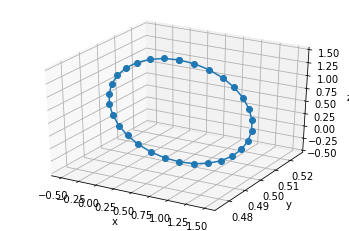

In [149]:
# Plot geometry of the system
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(np.array(circle)[:,0],np.array(circle)[:,1],np.array(circle)[:,2],'-o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
fig.clear()

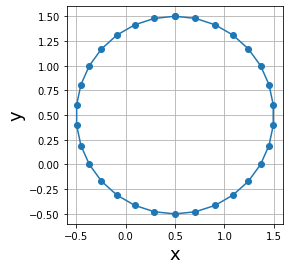

In [150]:
# Plot geometry of the system
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.grid()
ax.plot(np.array(circle)[:,0],np.array(circle)[:,2],'-o')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
plt.show()
fig.clear()

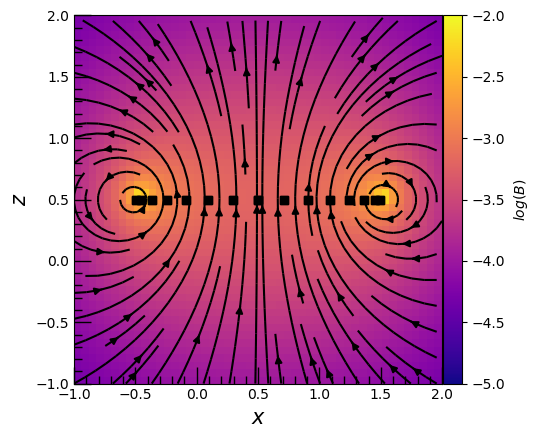

In [151]:
# computing magnetic field for each wire segment of the loop
Bx,By,Bz=0,0,0
counter=0

for i in range(len(circle)-1):
    BX,BY,BZ = Bvector(x,y,z, [circle[counter],circle[counter+1]], I) 
    Bx += BX
    By += BY
    Bz += BZ
    counter+=1

# magnitude of the magnetic field
Bmag = np.sqrt(Bx**2+By**2+Bz**2)

# plotting magnetic field 
fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x[:,:,zplane], y[:,:,zplane], np.log10(abs(Bmag[:,:,zplane])), vmin=-5, vmax=-2, cmap='plasma')
ax.streamplot(x[:,:,zplane], y[:,:,zplane], Bx[:,:,zplane], By[:,:,zplane],color='k')
ax.plot(np.array(circle)[:,0],np.array(circle)[:,1],'sk')

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$z$", fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

plt.show()
fig.clear()

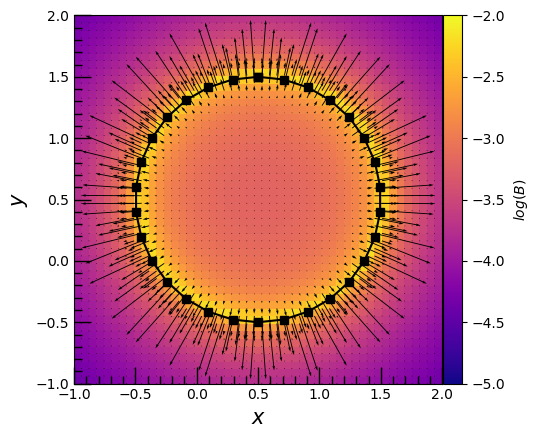

In [152]:
# plotting magnetic field (up view) 
yplane=round(N/2) # plane y=0

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
ax.minorticks_on()
ax.set_aspect(aspect=1)
ax.tick_params('both', length=12, width=1, which='major', direction='in')
ax.tick_params('both', length=6, width=1, which='minor', direction='in')

im = ax.pcolormesh(x[yplane,:,:], z[yplane,:,:], np.log10(abs(Bmag[yplane,:,:])), vmin=-5, vmax=-2, cmap='plasma') # , vmin=-8, vmax=-2
ax.quiver(x[yplane,:,:], z[yplane,:,:], Bx[yplane,:,:], Bz[yplane,:,:])
ax.plot(np.array(circle)[:,0],np.array(circle)[:,2],'-sk')

ax.set_xlim(-1,2)
ax.set_ylim(-1,2)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.01)
cb = fig.colorbar(im, ax=ax, orientation="vertical", cax=cax)
cb.set_label("$log(B)$", labelpad=5)

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$y$", fontsize=15)

plt.show()
fig.clear()

In [153]:
z_plot = np.linspace(-1, 2, N)  # spatial points in z 

In [154]:
Bz.shape

(50, 50, 50)

In [155]:
len(z_plot)

50

Text(0, 0.5, '$\\log_{10}{(B_{z})}$')

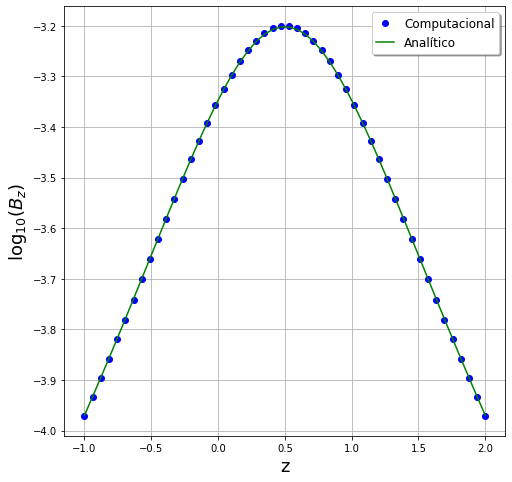

In [187]:
plt.plot(z[int(N/2),int(N/2),:], np.log10(Bmag[:,int(N/2),int(N/2)]), 'bo')
R=1
B_an = Bcoil(z_plot-R/2,R,I,1)
plt.plot(z_plot, np.log10(B_an),'g')
plt.grid()
plt.rcParams['figure.figsize'] = (7.9,7.9)
plt.legend(("Computacional", "Analítico"), shadow=True, handlelength=1.5, fontsize=12, loc='best')
plt.xlabel("z", fontsize=18)
plt.ylabel("$\log_{10}{(B_{z})}$", fontsize=18)

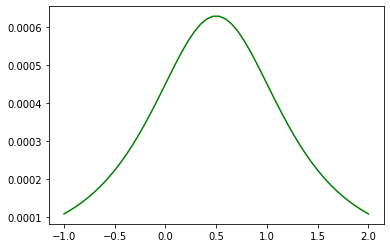

In [158]:
R=1
B_an = Bcoil(z_plot-R/2,R,I,1)
B_an_log = np.log10(B_an)
plt.plot(z_plot, B_an,'g')